In [ ]:

import calendar
from copy import deepcopy
import csv
import datetime
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


import matplotlib
import matplotlib.pyplot as plt

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from pylab import rcParams

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import stats

import seaborn as sns

import pytz

from google.colab import drive
drive.mount('/content/drive/')

!pip install influxdb
import influxdb

HOST = 'influx.linklab.virginia.edu'
PORT = 443
USERNAME = 'cps1f23'
PASSWORD = 'phah7goohohng5ooL9mae1quohpei1Ahsh1uGing'
DATABASE = 'gateway-generic'

client = influxdb.InfluxDBClient(HOST, PORT, USERNAME, PASSWORD, DATABASE, ssl=True, verify_ssl=True)

Mounted at /content/drive/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 3.0 MB/s eta 0:00:00


# Run CO2 clustering and Power classification without data smoothing.

In [ ]:
full_241_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/241_data_1.csv")
#other rooms moved to their own section later in the notebook
#full_243_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/243_data_1.csv")
#full_269_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/269_data_1.csv")
#full_241_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/241_data_1.csv")
full_241_df["time"] = pd.to_datetime(full_241_df["time"])
full_241_df['hour_of_day'] = full_241_df['time'].dt.hour
full_241_df

,Unnamed: 0,time,power,device_id_x,location_specific,co2,device_id_y,hour_of_day
0,0,2024-08-01 00:00:00+00:00,13.429019,ELEUV0202SM1Jb,241 Olsson,455.083333,70886b123039,0
1,1,2024-08-01 00:10:00+00:00,13.884922,ELEUV0202SM1Jb,241 Olsson,458.700000,70886b123039,0
2,2,2024-08-01 00:20:00+00:00,13.338876,ELEUV0202SM1Jb,241 Olsson,461.566667,70886b123039,0
3,3,2024-08-01 00:30:00+00:00,13.452444,ELEUV0202SM1Jb,241 Olsson,463.508475,70886b123039,0
4,4,2024-08-01 00:40:00+00:00,13.683276,ELEUV0202SM1Jb,241 Olsson,465.035714,70886b123039,0
...,...,...,...,...,...,...,...,...
13244,13244,2024-10-31 23:20:00+00:00,13.669773,ELEUV0202SM1Jb,241 Olsson,449.344828,70886b123039,23
13245,13245,2024-10-31 23:30:00+00:00,13.797541,ELEUV0202SM1Jb,241 Olsson,449.416667,70886b123039,23
13246,13246,2024-10-31 23:40:00+00:00,13.321689,ELEUV0202SM1Jb,241 Olsson,452.766667,70886b123039,23
13247,13247,2024-10-31 23:50:00+00:00,13.919588,ELEUV0202SM1Jb,241 Olsson,450.566667,70886b123039,23


In [ ]:
def create_histogram(data, data_type, data_unit):
  plt.hist(data, bins='auto')

  plt.title(f"Histogram of {data_type} data")
  plt.xlabel(f"{data_type} ({data_unit})")
  plt.ylabel("Count")

  plt.show()

def graph_mean_std(data, data_type, data_unit):
  mean = np.mean(data).item()
  std_dev = np.std(data)

  # Create figure and axis
  fig, ax = plt.subplots()

  # Plot histogram
  ax.hist(data, bins=30, edgecolor='black', alpha=0.7, label='Data')

  # Add vertical lines and text for the three-sigma rule
  for i in range(1, 4):
      ax.axvline(mean + i*std_dev, color='red', linestyle='--', label=f'+{i}σ' if i == 1 else '')
      ax.axvline(mean - i*std_dev, color='blue', linestyle='--', label=f'-{i}σ' if i == 1 else '')
      ax.text(mean + i*std_dev, ax.get_ylim()[1]*0.8, f'+{i}σ', color='red', ha='center')
      ax.text(mean - i*std_dev, ax.get_ylim()[1]*0.8, f'-{i}σ', color='blue', ha='center')

  # Add vertical line and text for the mean
  ax.axvline(mean, color='green', linestyle='-', label='Mean')
  ax.text(mean, ax.get_ylim()[1]*0.9, 'Mean', color='green', ha='center')

  ax.legend()

  plt.title(f"{data_type} data")
  plt.xlabel(f"{data_type} ({data_unit})")
  plt.show()

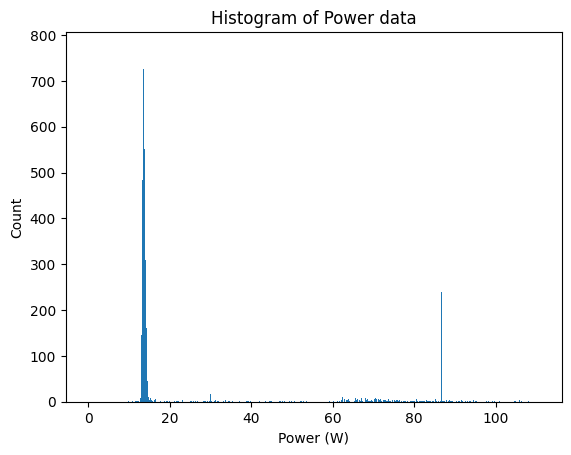

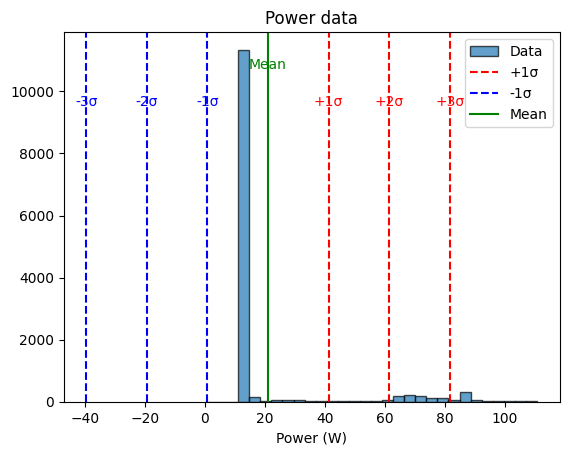

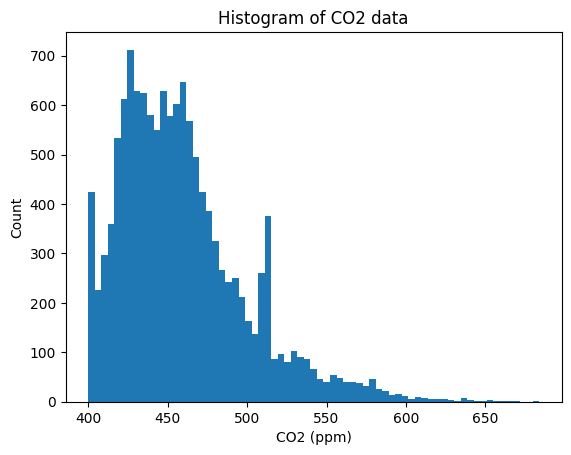

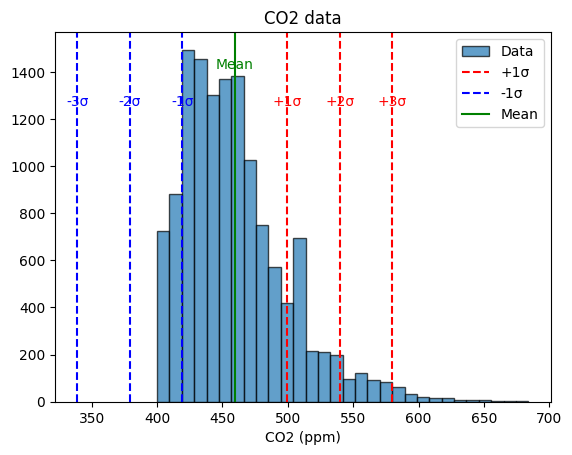

In [ ]:
power_data = full_241_df['power']
create_histogram(power_data, "Power", "W")
graph_mean_std(power_data, "Power", "W")

co2_data = full_241_df['co2']
create_histogram(co2_data, "CO2", "ppm")
graph_mean_std(co2_data, "CO2", "ppm")


(13249, 1)
(13249, 1)


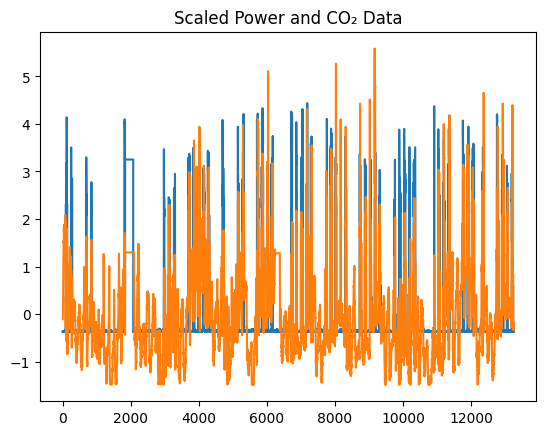

In [ ]:
power_data = full_241_df[["power"]].values.astype('float32')
co2_data = full_241_df[["co2"]].values.astype('float32')
power_data = np.clip(power_data, 13.4, None)

# Extract the power and co2 columns
scaler = StandardScaler()
power_data = scaler.fit_transform(power_data)
co2_data = scaler.fit_transform(co2_data)

print(power_data.shape)
print(co2_data.shape)

# Plot the scaled timeseries
plt.plot(power_data, label='Scaled Power')
plt.plot(co2_data, label='Scaled CO₂')
plt.title("Scaled Power and CO₂ Data")
plt.show()

In [ ]:
# K-means with 2 clusters
def apply_kmeans(data, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    return kmeans, labels

def graph_k_means(data, data_type, kmeans, labels):
  centroids = kmeans.cluster_centers_
  occupied_label = np.argmax(centroids)  # Index of the higher centroid
  binary_labels = np.where(labels == occupied_label, 1, 0)

  time = np.arange(len(data))

  plt.figure(figsize=(10, 6))
  plt.scatter(time, data, c=labels, cmap='viridis', marker='o', alpha=0.6)
  plt.xlabel('Time')
  plt.ylabel(f'{data_type} Levels')
  plt.title(f'K-means Clustering of {data_type} Levels Over Time')
  plt.colorbar(label='Cluster')
  plt.show()

  plt.figure(figsize=(10, 6))
  plt.hist(data[labels == 0], bins=30, alpha=0.6, label='Cluster 0')
  plt.hist(data[labels == 1], bins=30, alpha=0.6, label='Cluster 1')
  plt.xlabel(f'{data_type} Levels')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {data_type} Levels by Cluster')
  plt.legend()
  plt.show()

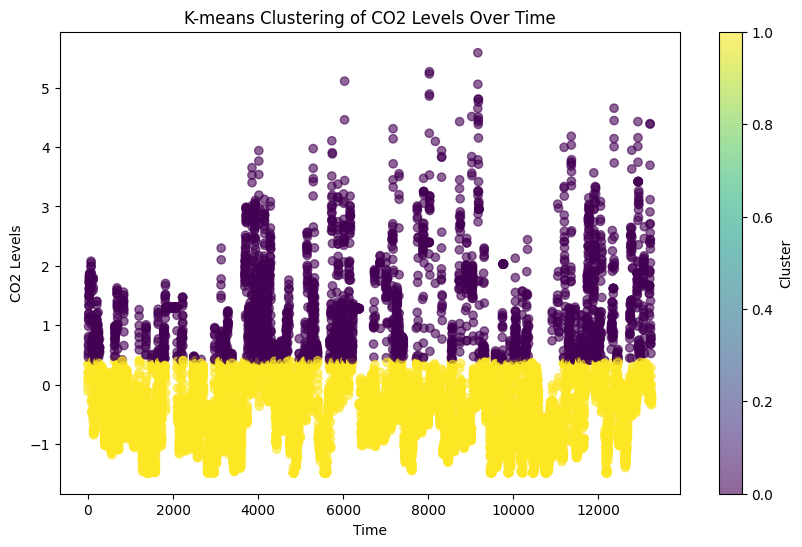

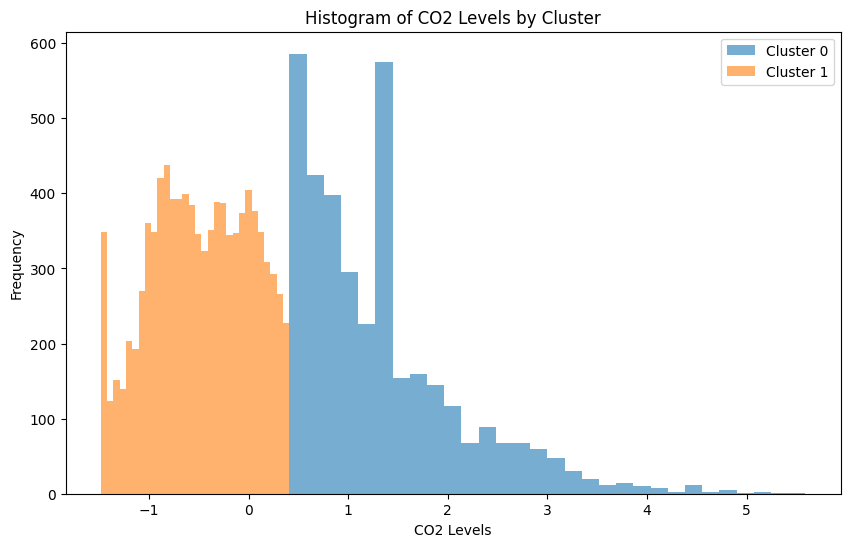

In [ ]:
kmeans, binary_labels = apply_kmeans(co2_data, num_clusters=2)
graph_k_means(co2_data, "CO2", kmeans, binary_labels)

In [ ]:
def run_random_forest(X_train, X_test, y_train, y_test, binary_labels):
  # Initialize the random forest classifier
  rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

  # Train the model
  rf_classifier.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = rf_classifier.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

  # Print classification report for more insights
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  # Confusion matrix
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  return rf_classifier

In [ ]:
  X = power_data.reshape(-1, 1)  # Reshape if necessary to make it a 2D array for sklearn
  y = binary_labels
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  rf_classifier = run_random_forest(X_train, X_test, y_train, y_test, binary_labels)

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       688
           1       0.85      0.89      0.87      1962

    accuracy                           0.80      2650
   macro avg       0.74      0.72      0.73      2650
weighted avg       0.79      0.80      0.80      2650

Confusion Matrix:
[[ 384  304]
 [ 225 1737]]


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the optimized model
y_pred_optimized = best_rf_classifier.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {accuracy_optimized:.2f}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Optimized Accuracy: 0.83


# Run CO2 clustering and Power classification WITH data smoothing.

In [ ]:
def calculate_rolling_statistics(data, window=10):
    """
    Calculate rolling mean, median, max, and min for the given data.
    """
    rolling_stats = {
        'mean': data.rolling(window=window).mean(),
        'median': data.rolling(window=window).median(),
        'max': data.rolling(window=window).max(),
        'min': data.rolling(window=window).min()
    }
    return rolling_stats

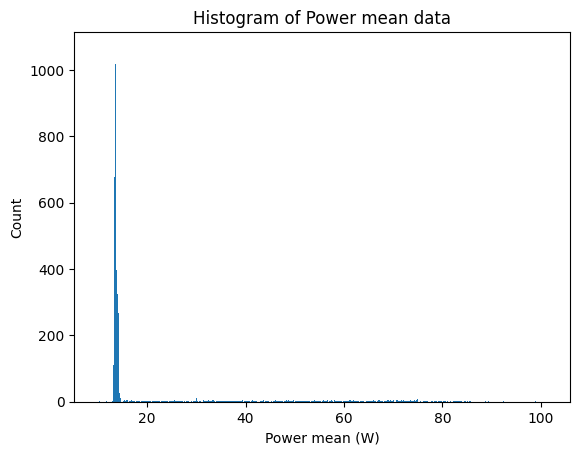

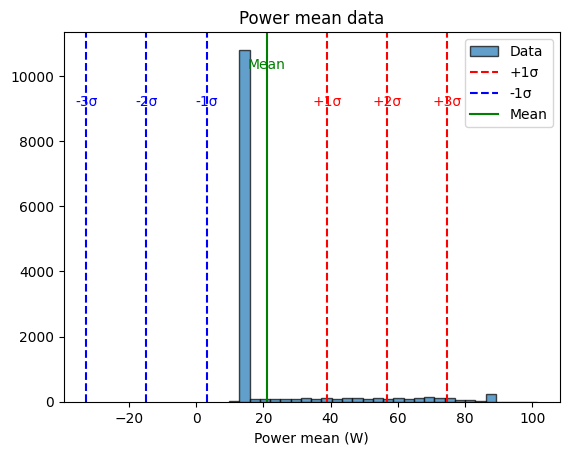

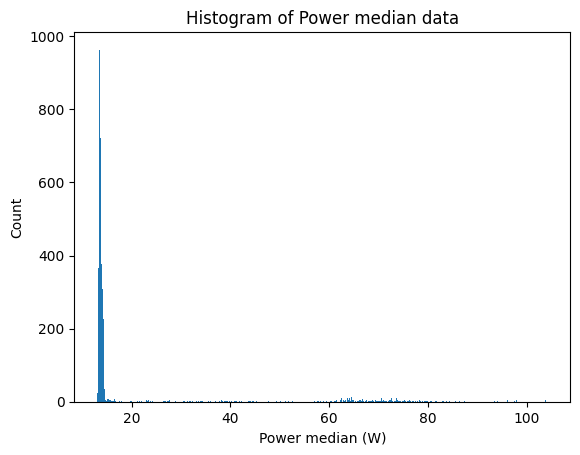

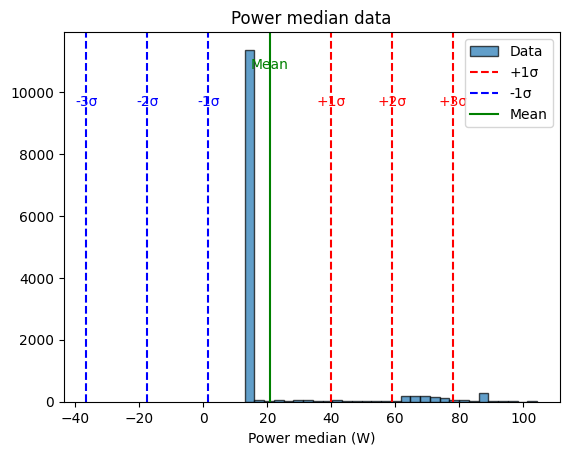

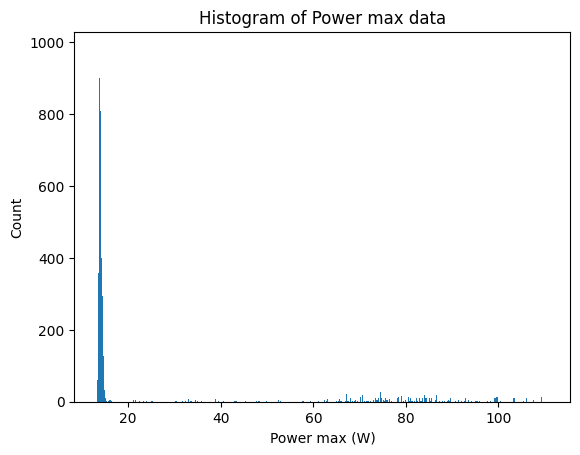

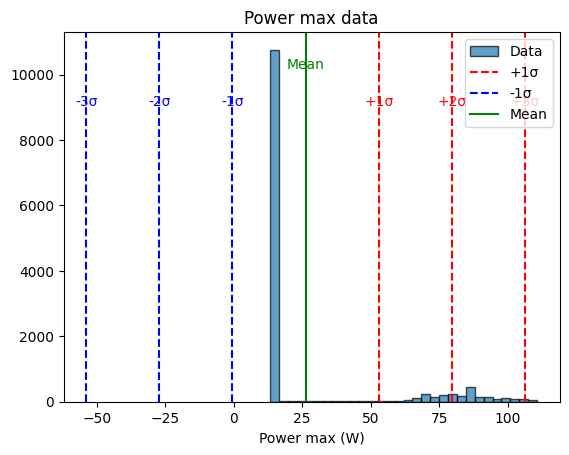

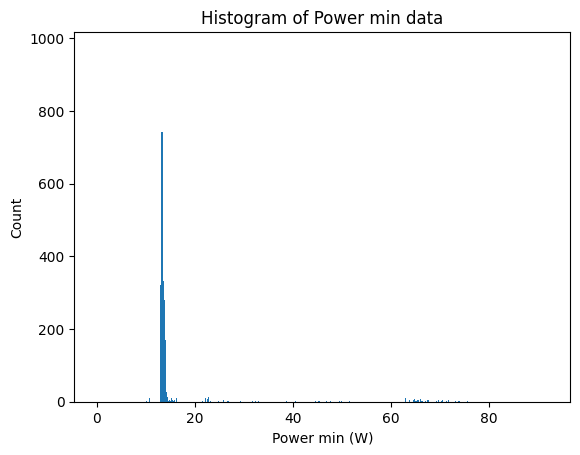

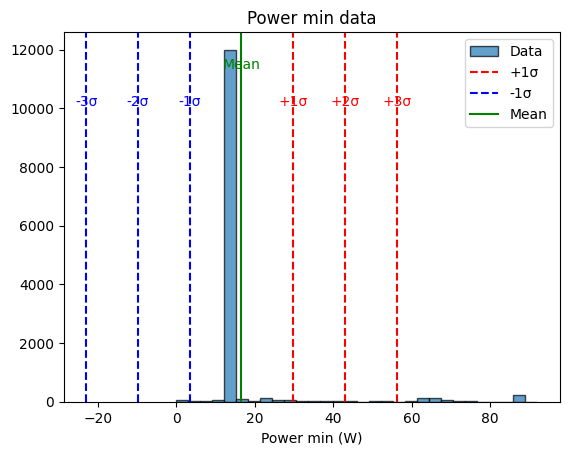

In [ ]:
power_data = full_241_df['power']
power_stats = calculate_rolling_statistics(power_data, window=10)
for stat in power_stats:
  create_histogram(power_stats[stat], f"Power {stat}", "W")
  graph_mean_std(power_stats[stat], f"Power {stat}", "W")

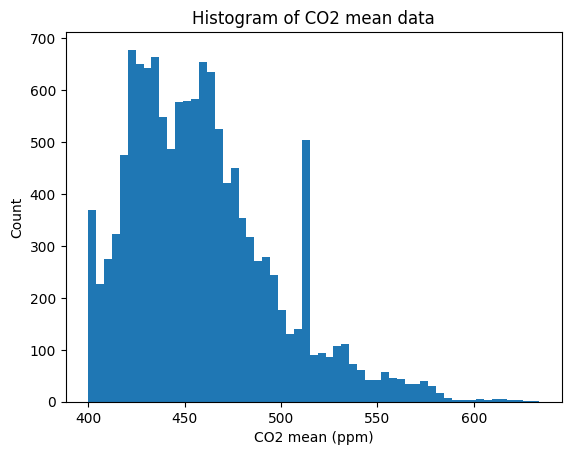

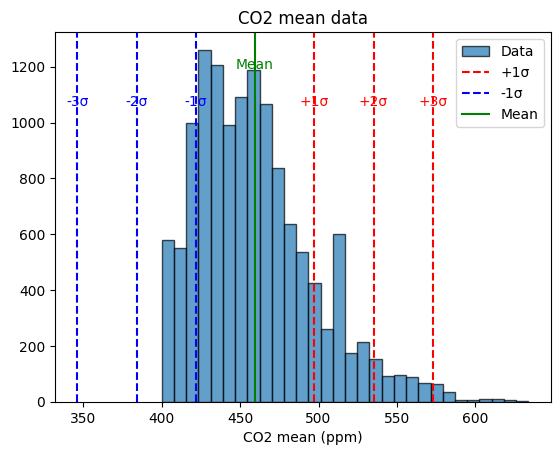

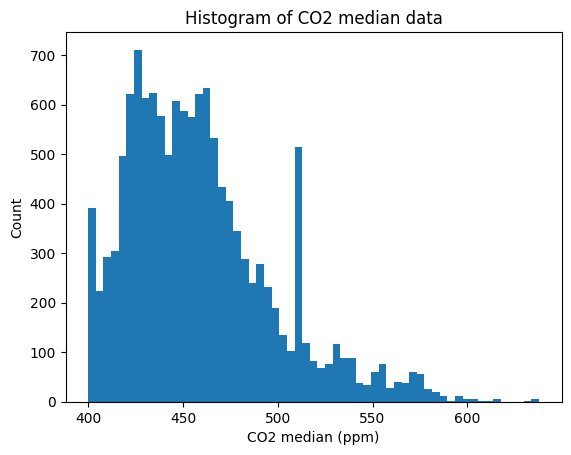

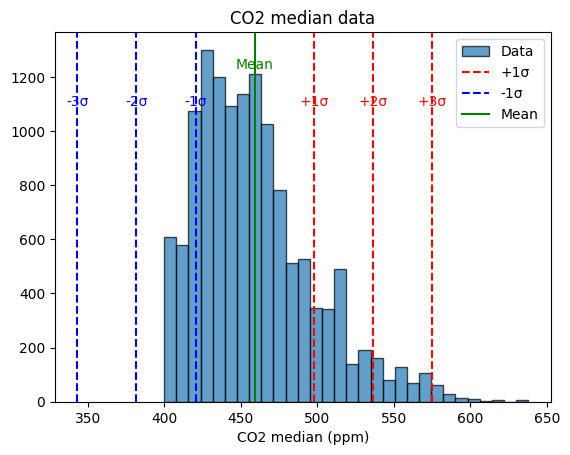

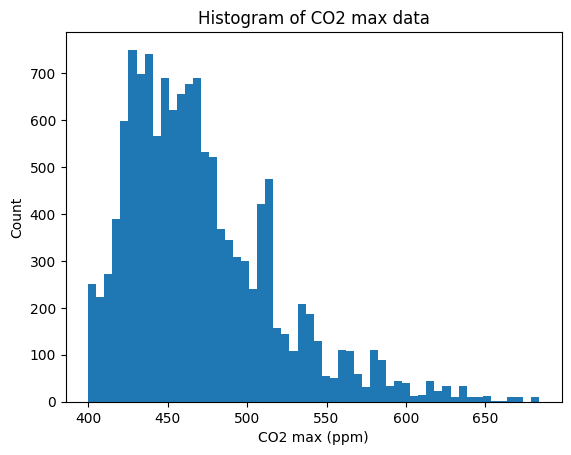

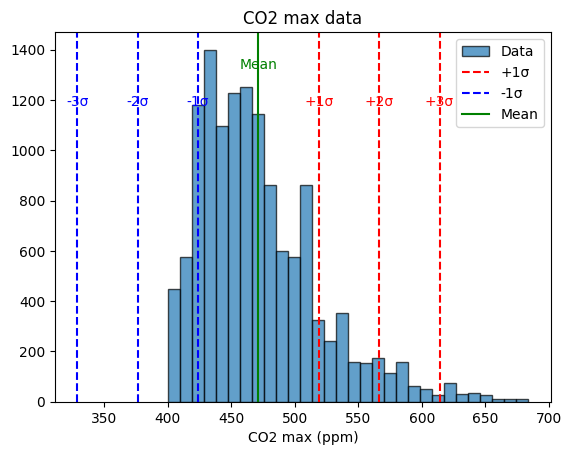

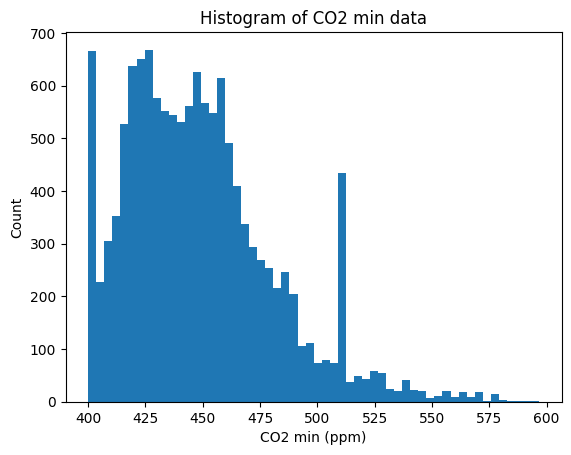

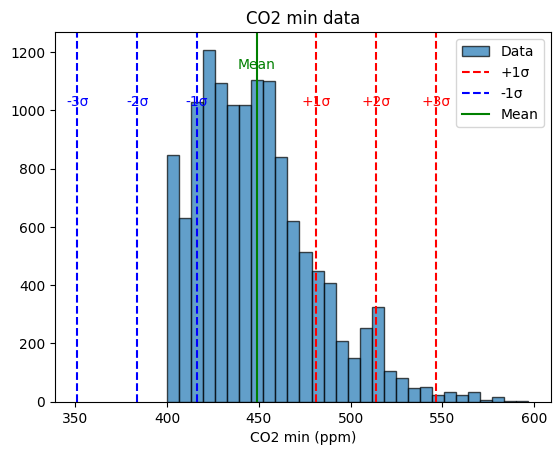

In [ ]:
co2_data = full_241_df['co2']
co2_stats = calculate_rolling_statistics(co2_data, window=10)
for stat in co2_stats:
  create_histogram(co2_stats[stat], f"CO2 {stat}", "ppm")
  graph_mean_std(co2_stats[stat], f"CO2 {stat}", "ppm")

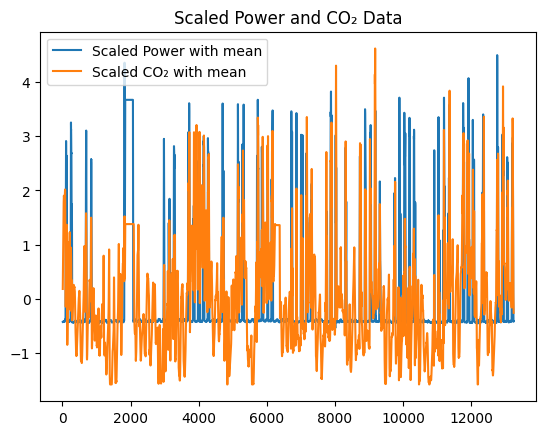

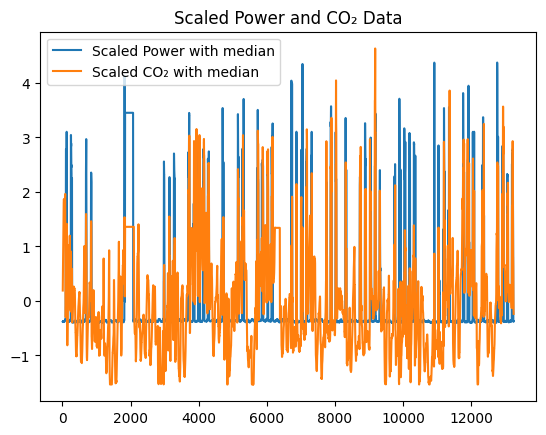

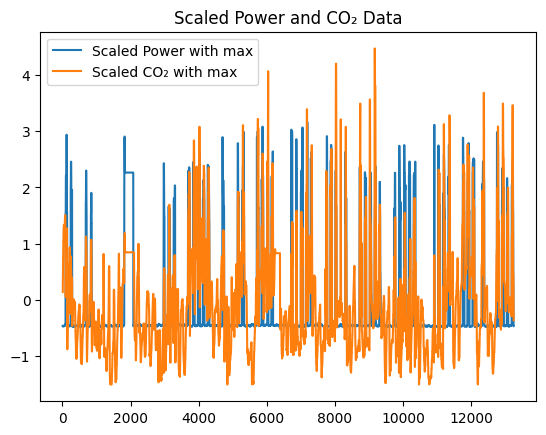

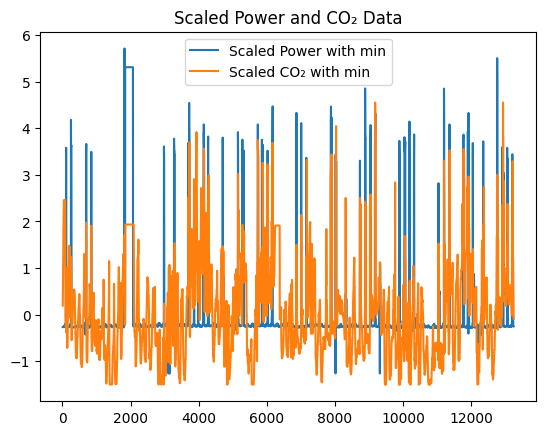

Running analysis for  mean


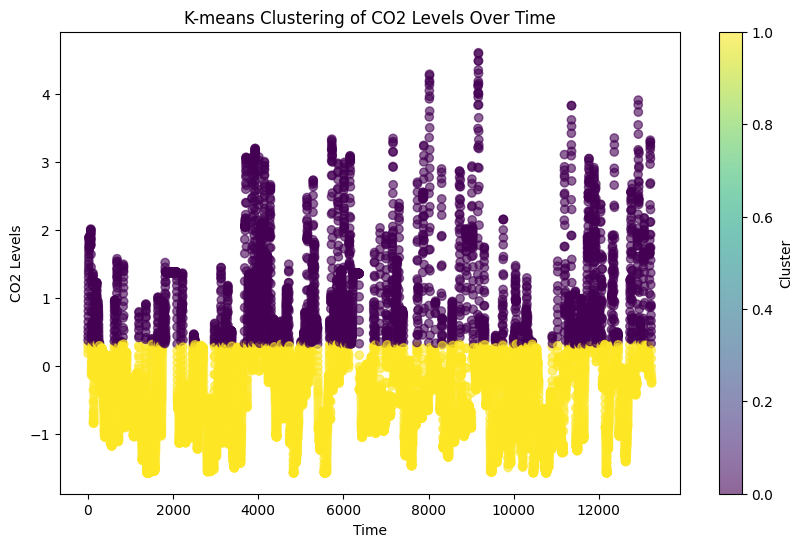

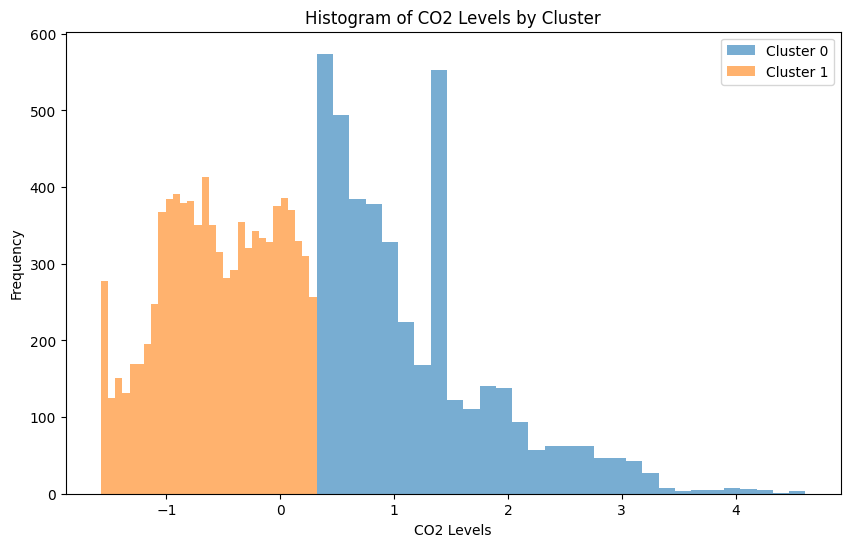

Results for mean: 
Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       808
           1       0.79      0.78      0.78      1840

    accuracy                           0.70      2648
   macro avg       0.65      0.65      0.65      2648
weighted avg       0.70      0.70      0.70      2648

Confusion Matrix:
[[ 414  394]
 [ 399 1441]]
Running analysis for  median


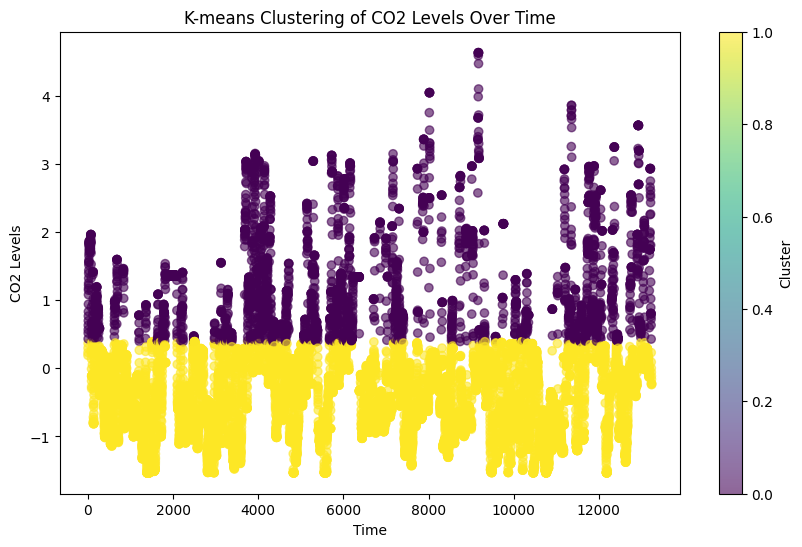

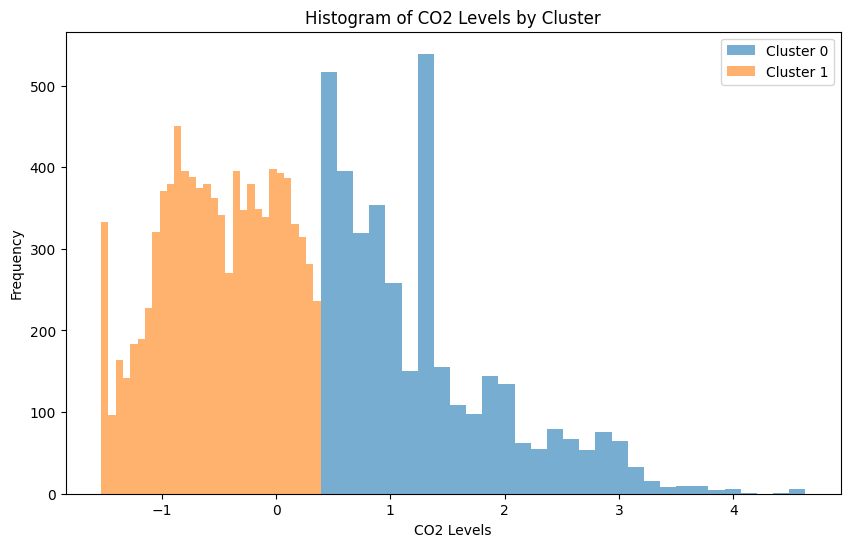

Results for median: 
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       717
           1       0.92      0.91      0.92      1931

    accuracy                           0.88      2648
   macro avg       0.84      0.85      0.85      2648
weighted avg       0.88      0.88      0.88      2648

Confusion Matrix:
[[ 570  147]
 [ 178 1753]]
Running analysis for  max


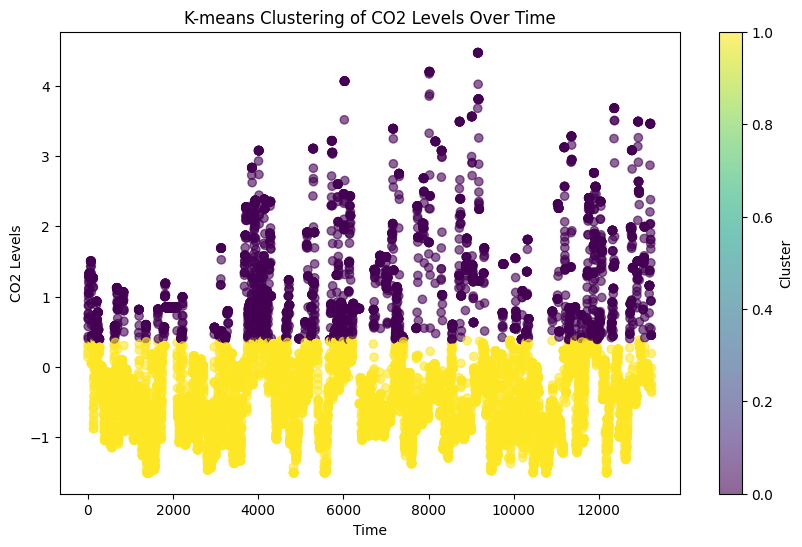

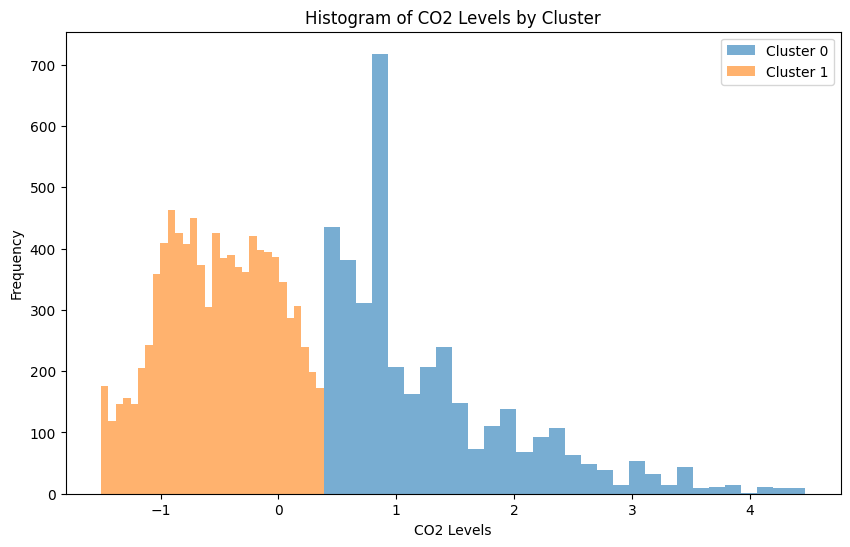

Results for max: 
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       715
           1       0.97      0.97      0.97      1933

    accuracy                           0.95      2648
   macro avg       0.94      0.94      0.94      2648
weighted avg       0.95      0.95      0.95      2648

Confusion Matrix:
[[ 658   57]
 [  63 1870]]
Running analysis for  min


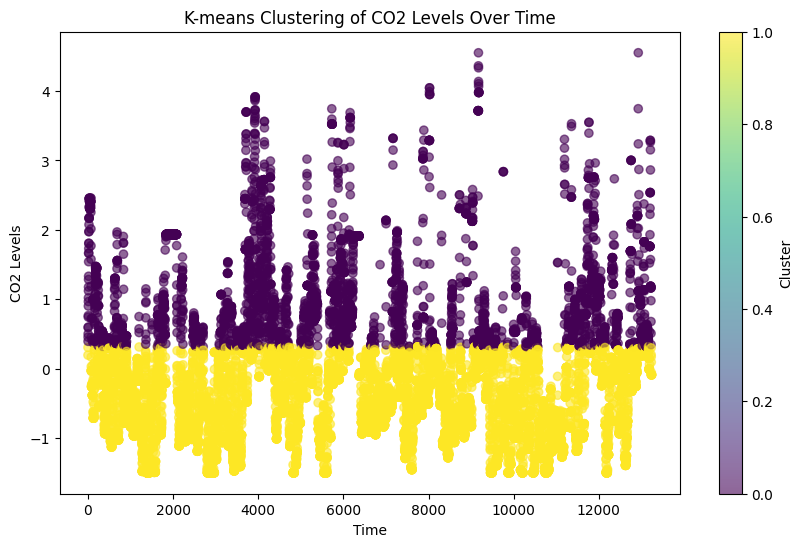

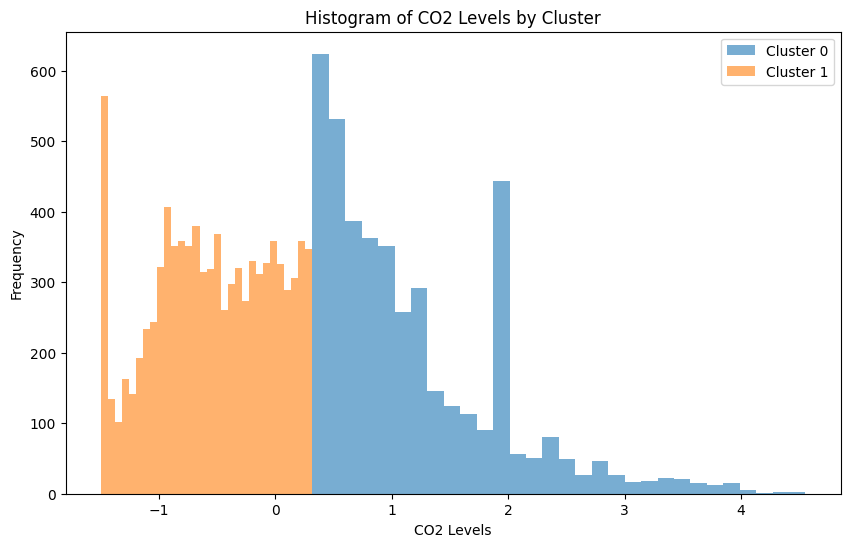

Results for min: 
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       840
           1       0.95      0.97      0.96      1808

    accuracy                           0.94      2648
   macro avg       0.94      0.93      0.94      2648
weighted avg       0.94      0.94      0.94      2648

Confusion Matrix:
[[ 742   98]
 [  48 1760]]


In [ ]:
co2_data = full_241_df['co2']
co2_stats = calculate_rolling_statistics(co2_data, window=10)
power_data = full_241_df['power']
power_stats = calculate_rolling_statistics(power_data, window=10)

scaler = StandardScaler()
power_data = full_241_df[["power"]].values.astype('float32')
co2_data = full_241_df[["co2"]].values.astype('float32')

# power_data=np.expand_dims(power_data, axis=-1)
# co2_data=np.expand_dims(co2_data, axis=-1)
for stat in power_stats:
  if isinstance(power_stats[stat], pd.Series):
    power_stats[stat] = power_stats[stat].to_numpy()
  power_stats[stat] = power_stats[stat].reshape(-1, 1)
  if isinstance(co2_stats[stat], pd.Series):
    co2_stats[stat] = co2_stats[stat].to_numpy()
  co2_stats[stat] = co2_stats[stat].reshape(-1, 1)

# Apply scaling and plot
for stat in power_stats:
    power_stats[stat] = scaler.fit_transform(power_stats[stat])
    co2_stats[stat] = scaler.fit_transform(co2_stats[stat])

    # Plot scaled time series
    plt.plot(power_stats[stat], label=f'Scaled Power with {stat}')
    plt.plot(co2_stats[stat], label=f'Scaled CO₂ with {stat}')
    plt.title("Scaled Power and CO₂ Data")
    plt.legend()
    plt.show()

metrics = power_stats.keys()
rf_classifiers = []
for stat in metrics:
  print("Running analysis for ", stat)
  # First 9 are nan since we are doing a sliding window of size 10 ... adjust this if we change window size
  cur_co2_stat = co2_stats[stat][9:]
  cur_power_stat = power_stats[stat][9:]

  kmeans, binary_labels = apply_kmeans(cur_co2_stat, num_clusters=2)
  graph_k_means(cur_co2_stat, "CO2", kmeans, binary_labels)

  X = cur_power_stat.reshape(-1, 1)  # Reshape if necessary to make it a 2D array for sklearn
  y = binary_labels
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print(f"Results for {stat}: ")
  rf_classifier = run_random_forest(X_train, X_test, y_train, y_test, binary_labels)
  rf_classifiers.append(rf_classifier)


In [ ]:
rf_classifiers[-1]

RandomForestClassifier(random_state=42)

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

stat = 'max'
cur_co2_stat = co2_stats[stat][9:]
cur_power_stat = power_stats[stat][9:]

kmeans, binary_labels = apply_kmeans(cur_co2_stat, num_clusters=2)
X = cur_power_stat.reshape(-1, 1)  # Reshape if necessary to make it a 2D array for sklearn
y = binary_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the GridSearchCV
rf_classifier = rf_classifiers[-1] # best one was using min/max value, so running param search on that one
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best estimator
best_rf_classifier = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the optimized model
y_pred_optimized = best_rf_classifier.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {accuracy_optimized:.2f}")

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Accuracy: 0.96


# Error Analysis

In [ ]:
#with reference to: https://datascience.stackexchange.com/questions/37899/sklearn-svm-how-to-get-a-list-of-the-wrong-predictions
errors = []

for input, prediction, label in zip(X_test, y_pred_optimized, y_test):
  if prediction != label:
    print(input, 'has been classified as ', prediction, 'and should be ', label)
    errors.append(input)

[2.45964975] has been classified as  0 and should be  1
[-0.44833832] has been classified as  0 and should be  1
[-0.46390733] has been classified as  0 and should be  1
[-0.45958728] has been classified as  1 and should be  0
[0.86723715] has been classified as  0 and should be  1
[-0.44145197] has been classified as  1 and should be  0
[0.71565756] has been classified as  1 and should be  0
[-0.43862654] has been classified as  1 and should be  0
[-0.46838548] has been classified as  1 and should be  0
[-0.43785986] has been classified as  1 and should be  0
[-0.46257521] has been classified as  0 and should be  1
[-0.4607158] has been classified as  1 and should be  0
[-0.45344225] has been classified as  0 and should be  1
[-0.43639006] has been classified as  0 and should be  1
[-0.43692938] has been classified as  1 and should be  0
[0.27657019] has been classified as  1 and should be  0
[-0.04561058] has been classified as  0 and should be  1
[1.5024389] has been classified as  

In [ ]:
x_e_index = []
for error in errors:
  x_e_index.append(np.where(X_test == error)[0][0])
x_e_index

[35,
 31,
 88,
 114,
 153,
 5,
 279,
 309,
 315,
 347,
 350,
 367,
 389,
 391,
 408,
 498,
 507,
 509,
 658,
 715,
 732,
 741,
 744,
 748,
 770,
 803,
 804,
 830,
 850,
 47,
 898,
 910,
 930,
 936,
 240,
 949,
 972,
 988,
 1021,
 1063,
 1086,
 1091,
 240,
 1146,
 1148,
 1161,
 1163,
 1179,
 1202,
 1161,
 1241,
 1252,
 980,
 1281,
 1284,
 715,
 1299,
 1307,
 1327,
 1332,
 1338,
 769,
 1362,
 1372,
 1393,
 1441,
 860,
 386,
 1101,
 1610,
 1631,
 1643,
 1664,
 1086,
 320,
 1741,
 504,
 1784,
 1790,
 1805,
 1822,
 1827,
 825,
 1878,
 511,
 391,
 825,
 936,
 1927,
 1241,
 1959,
 1970,
 1631,
 1984,
 351,
 2076,
 898,
 2348,
 2371,
 2401,
 2427,
 2443,
 930,
 227,
 1318,
 2488,
 1625,
 161,
 2529,
 2072,
 2554,
 2555,
 2598,
 533,
 1591,
 732]

In [ ]:
import random

to_graph = random.randint(0, len(x_e_index)-1)
print(to_graph)
to_graph = x_e_index[to_graph]
print(to_graph)

8
315


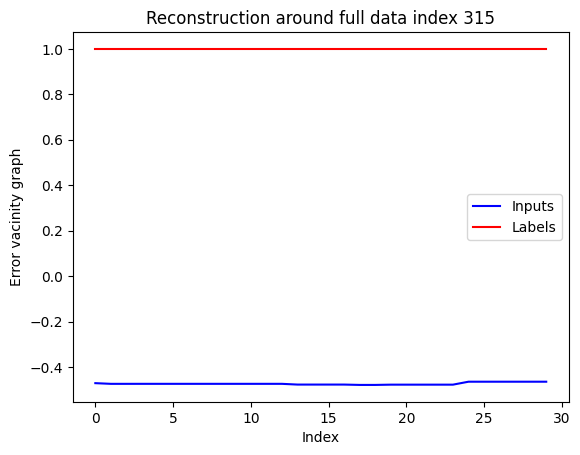

In [ ]:
x_slice = X[to_graph-15:to_graph+15]
y_slice = y[to_graph-15:to_graph+15]

# Plot the original data
plt.plot(x_slice, label='Inputs', color='blue')

# Plot the replaced data
plt.plot(y_slice, label='Labels', color='red')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Error vacinity graph')
plt.title('Reconstruction around full data index %i' % to_graph)
plt.legend()

# Show the plot
plt.show()

# LSTM work ... leaving here in case we need it for some reason

In [ ]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

print("Training Data:")
print(train)
print("\n\nTest Data:")
print(test)

Training Data:
[[-0.37742084 -0.11051809]
 [-0.354832   -0.02039535]
 [-0.3788587   0.05103835]
 ...
 [-0.36056858 -0.7449073 ]
 [-0.36056858 -0.3668505 ]
 [ 3.2582207   1.2486424 ]]


Test Data:
[[ 3.1660776   1.6076269 ]
 [ 3.0387123   1.7546479 ]
 [ 3.070484    1.9265862 ]
 ...
 [-0.3788587  -0.16824679]
 [-0.35311437 -0.2230675 ]
 [-0.3565059  -0.2230675 ]]


In [ ]:
# Window the time series data and convert to 3D tensor
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i + lookback, 0]  # Only use 'power' as feature
        target = dataset[i + lookback, 1]  # Predict the 'co2_level'
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [ ]:
from sklearn.model_selection import train_test_split

lookback = 10 # based on what the code from class used/paper they used
X_train, X_val = train_test_split(train, test_size=0.2, shuffle=False)

X_train, y_train = create_dataset(X_train, lookback=lookback)
X_val, y_val = create_dataset(X_val, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([7090, 10]) torch.Size([7090])
torch.Size([1766, 10]) torch.Size([1766])
torch.Size([4363, 10]) torch.Size([4363])


In [ ]:
# Reshape to (batch_size, sequence_length, num_features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [ ]:
# Convert sequences to torch tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()

<ipython-input-143-411c34585a52>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-143-411c34585a52>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float()
<ipython-input-143-411c34585a52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets with both inputs and targets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([7090, 10, 1])
torch.Size([1766, 10, 1])
torch.Size([4363, 10, 1])


In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMPredictor, self).__init__()

        # Encoder LSTM
        self.encoder = nn.LSTM(input_dim, hidden_dim, 1, batch_first=True)

        # Linear layer for prediction
        self.linear = nn.Linear(hidden_dim, 1)  # Output a single CO2 prediction

    def forward(self, x):
        # Encoding
        _, (hidden, _) = self.encoder(x)

        # Use the final hidden state for prediction
        out = self.linear(hidden[-1])  # Shape: (batch_size, 1)

        return out

In [ ]:
# Model parameters
input_dim = 1  # Power input feature
hidden_dim = 16  # LSTM output dimensionality
seq_len = 10  # Number of time steps per sequence
model = LSTMPredictor(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
class SimpleEarlyStopping:
    def __init__(self, patience=5, min_delta=0.00):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def check_early_stop(self, loss):
        if loss + self.min_delta < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [ ]:
import torch.utils.data as data
import torch.optim as optim

# Assuming input_dim and hidden_dim are defined
input_dim = 1
hidden_dim = 50

# Instantiate model, optimizer, and loss function
model = LSTMPredictor(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Assuming X_train and y_train are defined tensors
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch).squeeze(-1)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Calculate RMSE for train and test sets
            y_train_pred = model(X_train).squeeze(-1)
            train_rmse = np.sqrt(loss_fn(y_train_pred, y_train).item())

            y_test_pred = model(X_test).squeeze(-1)
            test_rmse = np.sqrt(loss_fn(y_test_pred, y_test).item())

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


Epoch 0: train RMSE 0.8102, test RMSE 0.8699
Epoch 10: train RMSE 0.8028, test RMSE 0.8440
Epoch 20: train RMSE 0.8046, test RMSE 0.8457
Epoch 30: train RMSE 0.8043, test RMSE 0.8464
Epoch 40: train RMSE 0.8034, test RMSE 0.8467
Epoch 50: train RMSE 0.8031, test RMSE 0.8468
Epoch 60: train RMSE 0.8015, test RMSE 0.8466
Epoch 70: train RMSE 0.8003, test RMSE 0.8469
Epoch 80: train RMSE 0.7984, test RMSE 0.8485
Epoch 90: train RMSE 0.7967, test RMSE 0.8525
Epoch 100: train RMSE 0.7939, test RMSE 0.8569
Epoch 110: train RMSE 0.7935, test RMSE 0.8584
Epoch 120: train RMSE 0.7917, test RMSE 0.8634
Epoch 130: train RMSE 0.7918, test RMSE 0.8627
Epoch 140: train RMSE 0.7888, test RMSE 0.8699
Epoch 150: train RMSE 0.7866, test RMSE 0.8663
Epoch 160: train RMSE 0.7847, test RMSE 0.8726


KeyboardInterrupt: 

In [ ]:
# Prediction plotting
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size] = model(X_train).numpy().squeeze()
    test_plot = np.ones_like(timeseries[:, 2]) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test).numpy().squeeze()

plt.plot(timeseries[:, 2], label='True CO₂')
plt.plot(train_plot, label='Train Prediction', color='r')
plt.plot(test_plot, label='Test Prediction', color='g')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (7090,) into shape (8866,2)

# Follow Up: Other Rooms

In [ ]:
full_243_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/243_data_1.csv")
full_245_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/245_data_1.csv")
full_269_df = pd.read_csv("/content/drive/MyDrive/Fall 2024/Smart and Healthy Buildings/SAHB Energy Occupancy Group/269_data_1.csv")

full_243_df["time"] = pd.to_datetime(full_241_df["time"])
full_245_df["time"] = pd.to_datetime(full_241_df["time"])
full_269_df["time"] = pd.to_datetime(full_241_df["time"])


full_243_df['hour_of_day'] = full_241_df['time'].dt.hour
full_245_df['hour_of_day'] = full_241_df['time'].dt.hour
full_269_df['hour_of_day'] = full_241_df['time'].dt.hour

full_269_df

,Unnamed: 0,time,power,device_id_x,location_specific,co2,device_id_y,hour_of_day
0,0,2024-08-01 00:00:00+00:00,142.064017,ELEUV0202SM1Bc,269 Olsson,434.357143,70886b126223,0
1,1,2024-08-01 00:10:00+00:00,142.389701,ELEUV0202SM1Bc,269 Olsson,434.357143,70886b126223,0
2,2,2024-08-01 00:20:00+00:00,143.439275,ELEUV0202SM1Bc,269 Olsson,434.357143,70886b126223,0
3,3,2024-08-01 00:30:00+00:00,142.598587,ELEUV0202SM1Bc,269 Olsson,434.357143,70886b126223,0
4,4,2024-08-01 00:40:00+00:00,142.687236,ELEUV0202SM1Bc,269 Olsson,434.357143,70886b126223,0
...,...,...,...,...,...,...,...,...
13244,13244,2024-10-31 23:20:00+00:00,97.971807,ELEUV0202SM1Bc,269 Olsson,715.600000,70886b126223,23
13245,13245,2024-10-31 23:30:00+00:00,90.957944,ELEUV0202SM1Bc,269 Olsson,706.700000,70886b126223,23
13246,13246,2024-10-31 23:40:00+00:00,93.955286,ELEUV0202SM1Bc,269 Olsson,660.483333,70886b126223,23
13247,13247,2024-10-31 23:50:00+00:00,99.694027,ELEUV0202SM1Bc,269 Olsson,644.733333,70886b126223,23
